# Aula 9 - PCA (Análise de Componentes Principais)


O conteúdo da aula de hoje foi baseado em:
1. Capítulo 7 do Livro *Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)
2. https://mathworld.wolfram.com/ProjectionMatrix.html
3. https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/
4. https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/l_sym_sed.html
5. Considerações do professor
6. ...

**WARNING:** em muitas partes da aula de hoje, estarei cometendo "abuso" de notação e simplificação. Para um tratamento formal, recomendo a referência 1, acima.

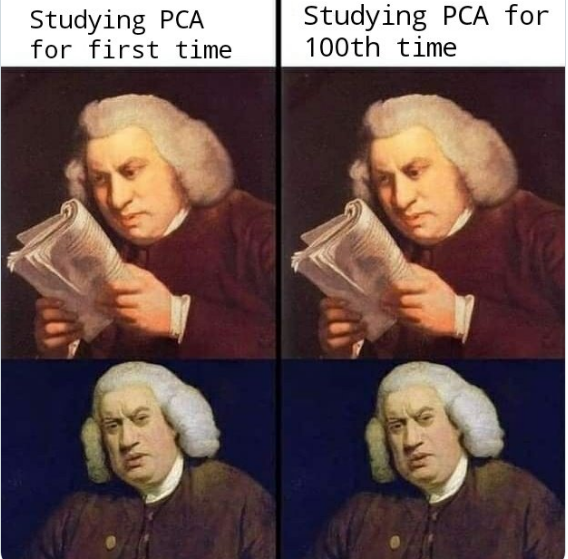

# Introdução

Da aula passada...

Em muitas situações, o conjunto de dados de interesse pode ser visto como uma matriz com $n$ linhas e $d$ colunas.

As linhas representam objetos (e.g., pessoas) e as colunas os atributos (e.g., peso, altura, idade, etc.).

$$\mathbf{X} = \begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1d} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{n1} & x_{n2} & x_{n3} & \dots  & x_{nd}
\end{bmatrix}
$$

O que acontece quando $n$ e $d$ são muito grandes?

1. Há um problema relacionado ao armazenamento e à eficiência algorítmica.

2. Maldição da dimensionalidade.

**O que fazer então?** Redução de dimensionalidade! Hoje veremos uma dessas técnicas, chamada de PCA (*Principal Component Analysis*).

# Preliminares (Parte 1)

## Vetores

Seja $\mathbf{x} \in \mathbb{R}^d$. Vamos seguir a convenção que $\mathbf{x}$ é uma matriz de $d$ linhas e uma coluna. Ou seja:
$$\begin{align}
    \mathbf{x} &= \begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{d}
         \end{bmatrix}
  \end{align}$$

  Para simplificar e reduzir espaço no texto, é comum escrevermos $\mathbf{x} = [x_1, \dots, x_d]^T$.

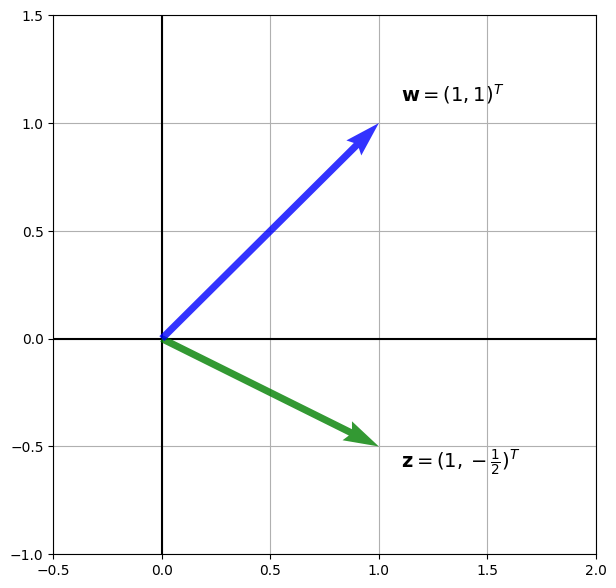

In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt

def orthogonal_projection(x, y):
  alpha = np.dot(x, y) / np.dot(y, y)
  return alpha * y

def plot_vector(v, color, org = np.array([0, 0]), zorder = 0, alpha = 0.8):
  plt.quiver(org[0], org[1], v[0], v[1],
       color = color,
       zorder = 10, alpha = alpha, width = 0.013, angles='xy', scale_units='xy', scale=1)

z = np.array([1, -0.5])
w = np.array([1, 1])

plt.figure(figsize = (7, 7))
plot_vector(z, "green")
plot_vector(w, "blue")
plt.plot([-10, 10], [0, 0], color = 'black')
plt.plot([0, 0], [-10, 10], color = 'black')
plt.annotate(r'$\mathbf{z} = (1, -\frac{1}{2})^T$', xy=z, xytext=z+[0.1, -0.1], size = 14)
plt.annotate(r'$\mathbf{w} = (1, 1)^T$', xy=z, xytext=w+[0.1, 0.1], size = 14)
plt.grid(True)
plt.xlim((-0.5, 2))
plt.ylim((-1, 1.5));

## Versão matricial do produto interno/escalar

Sejam $\mathbf{x}$ e $\mathbf{y}$ dois vetores do espaço $d$-dimensional real. Usando a notação acima, temos o seguinte sobre o produto interno:
$$\mathbf{x}\cdot \mathbf{y} = \sum_{i = 1}^d x_i y_i = \mathbf{x}^T\mathbf{y}.$$

## Projeção ortogonal

Considere o exemplo abaixo. Quando fazemos a **projeção ortogonal** do vetor $\mathbf{w}$ sobre o vetor $\mathbf{z}$, obtemos o vetor $\text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}}$.

**Pergunta:** quem é $\text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}}$ em função de $\mathbf{w}$ e $\mathbf{z}$?

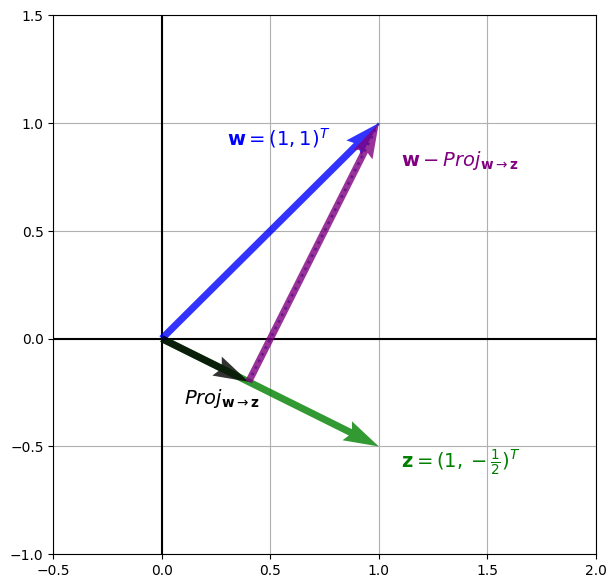

In [ ]:
z = np.array([1, -0.5])
w = np.array([1, 1])

proj_wz = orthogonal_projection(w, z)

diff = w - proj_wz
plt.figure(figsize = (7, 7))
plot_vector(z, "green")
plot_vector(w, "blue")

plt.plot([-10, 10], [0, 0], color = 'black')
plt.plot([0, 0], [-10, 10], color = 'black')
plt.annotate(r'$\mathbf{z} = (1, -\frac{1}{2})^T$', xy=z, xytext=z+[0.1, -0.1], size = 14, color = 'green')
plt.annotate(r'$\mathbf{w} = (1, 1)^T$', xy=z, xytext=w+[-0.7, -0.1], size = 14, color = 'blue')
plt.grid(True)
plt.xlim((-0.5, 2))
plt.ylim((-1, 1.5));

# 2
plt.plot([proj_wz[0], w[0]], [proj_wz[1], w[1]], linestyle = ':', linewidth = 2)

# 3
plot_vector(proj_wz, "black")
plt.annotate(r'$Proj_{\mathbf{w}\rightarrow\mathbf{z}}$', xy=proj_wz, xytext=proj_wz+[-0.3, -0.1], size = 14)

# 4
plot_vector(diff, "purple", org = proj_wz)
plt.annotate(r'$\mathbf{w} - Proj_{\mathbf{w}\rightarrow\mathbf{z}}$', xy=w - proj_wz, xytext=w - proj_wz+[0.5, -0.4], size = 14, color = 'purple');

Como $\text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}}$ está na mesma direção de $\mathbf{z}$, temos
$$\text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}} = \alpha \mathbf{z}.$$
Além disso, sabemos que
$\mathbf{z}$ e $\mathbf{w} - \text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}}$ são ortogonais. Logo

$$\mathbf{z}^T(\mathbf{w} - \text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}}) = 0.$$
Logo
$$\mathbf{z}^T(\mathbf{w} - \alpha\mathbf{z}) = 0.$$
Resolvendo a equação acima para $\alpha$, temos
$$\alpha = \frac{\mathbf{z}^T\mathbf{w}}{\mathbf{z}^T\mathbf{z}}.$$
Assim
$$\text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}} = \frac{\mathbf{z}^T\mathbf{w}}{\mathbf{z}^T\mathbf{z}}\mathbf{z}.$$

**Why should I care?**


## Projeções e subespaços

### Exemplo 1

Considere a transformação linear  $T: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ que mapeia $\mathbf{x}$ em $\mathbf{P}\mathbf{x}$, aonde
$$\mathbf{P} = \begin{bmatrix}
    \frac{4}{5} & -\frac{2}{5}\\
    -\frac{2}{5} & \frac{1}{5}
\end{bmatrix}$$

Vejamos o exemplo a seguir:

In [ ]:
# P
P = np.array([[0.8, -0.4], [-0.4, 0.2]])
P

array([[ 0.8, -0.4],
       [-0.4,  0.2]])

In [ ]:
# vetor w (mesmo w do exemplo anterior)
w

array([1, 1])

In [ ]:
# Pw -> Aplicação de P em w
np.dot(P, w)

array([ 0.4, -0.2])

In [ ]:
# Projeção de w em z (pela fórmula derivada acima)
(np.dot(z, w) / np.dot(z, z)) * z

array([ 0.4, -0.2])

Assim, a aplicação de $\mathbf{P}$ em $\mathbf{w}$ resulta em $\text{Proj}_{\mathbf{w}\rightarrow\mathbf{z}}$. Coincidência?

Vamos analisar mais alguns exemplos com o uso da figura abaixo.

In [ ]:
a = np.array([-0.75, -0.5])
b = np.array([1, -0.75])
z = np.array([1, -0.5])
w = np.array([1, 1])

# Pa
proj_az = np.dot(P, a)

# Pb
proj_bz = np.dot(P, b)

#Pw
proj_wz = np.dot(P, w)

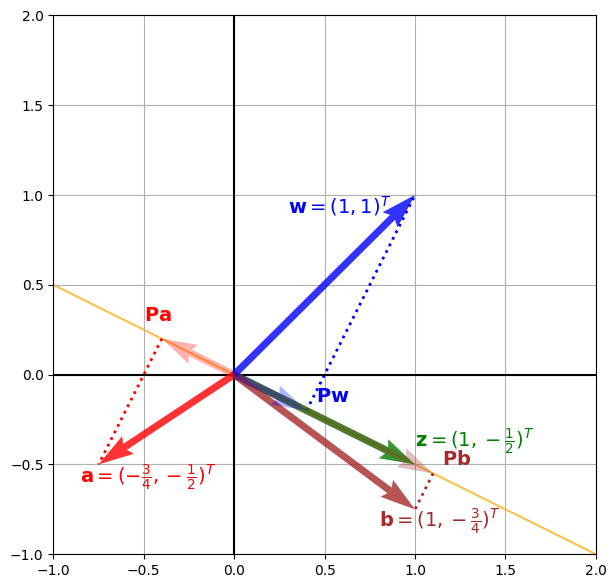

In [ ]:
plt.figure(figsize = (7, 7))

#1
plot_vector(z, "green")
plot_vector(a, "red")
plot_vector(b, "brown")
plot_vector(w, "blue")

plt.annotate(r'$\mathbf{z} = (1, -\frac{1}{2})^T$', xy=z, xytext=z+[0, 0.1], size = 14, color = 'green')
plt.annotate(r'$\mathbf{a} = (-\frac{3}{4}, -\frac{1}{2})^T$', xy=a, xytext=a+[-0.1, -0.1], size = 14, color = 'red')
plt.annotate(r'$\mathbf{b} = (1, -\frac{3}{4})^T$', xy=b, xytext=b+[-0.2, -0.1], size = 14, color = 'brown')
plt.annotate(r'$\mathbf{w} = (1, 1)^T$', xy=z, xytext=w+[-0.7, -0.1], size = 14, color = 'blue')

# 2
plt.plot([proj_az[0], a[0]], [proj_az[1], a[1]], linestyle = ':', linewidth = 2, color = 'red')
plt.plot([proj_bz[0], b[0]], [proj_bz[1], b[1]], linestyle = ':', linewidth = 2, color = 'brown')
plt.plot([proj_wz[0], w[0]], [proj_wz[1], w[1]], linestyle = ':', linewidth = 2, color = 'blue')
plot_vector(proj_az, "red", alpha = 0.3)
plot_vector(proj_bz, "brown", alpha = 0.3)
plot_vector(proj_wz, "blue", alpha = 0.3)

# 3
plt.annotate(r'$\mathbf{P}\mathbf{a}$', xy=proj_az, xytext=proj_az+[-0.1, 0.1], size = 14, color = 'red')
plt.annotate(r'$\mathbf{P}\mathbf{b}$', xy=proj_bz, xytext=proj_bz+[0.05, 0.05], size = 14, color = 'brown')
plt.annotate(r'$\mathbf{P}\mathbf{w}$', xy=proj_wz, xytext=proj_wz+[0.05, 0.05], size = 14, color = 'blue')

# 4
plt.plot([-8, 8], [4, -4], color = 'orange', alpha = 0.7, zorder = -1)

plt.plot([-10, 10], [0, 0], color = 'black')
plt.plot([0, 0], [-10, 10], color = 'black')
plt.grid(True)
plt.xlim((-1, 2))
plt.ylim((-1, 2));

Com o exemplo acima, pode-se perceber que, para qualquer $\mathbf{x} \in \mathbb{R}^2$, $\mathbf{Px}$ resulta em $\text{Proj}_{\mathbf{x}\rightarrow\mathbf{z}}$. O conjunto de todas essas projeções gera a linha laranja da figura.

E o que acontece se multiplicarmos um vetor duas vezes pela matriz $\mathbf{P}$?

In [ ]:
P

array([[ 0.8, -0.4],
       [-0.4,  0.2]])

In [ ]:
a

array([-0.75, -0.5 ])

In [ ]:
np.dot(P, a)

array([-0.4,  0.2])

In [ ]:
np.dot(P, np.dot(P, a))

array([-0.4,  0.2])

Veja que não há efeito em uma segunda aplicação da transformação! De fato, como $\mathbf{P}$ é uma matriz de projeção, tem-se que $\mathbf{P}^2 = \mathbf{P}$.

Agora repare que todos os pontos na linha laranja são da forma $\alpha \mathbf{z} = (\alpha, \frac{-\alpha}{2})^T$.

Considere o conjunto
$$S = \left\{\mathbf{x} \in \mathbb{R}^2| \mathbf{x} = \left(\alpha, -\frac{\alpha}{2}\right)^T,\ \alpha \in \mathbb{R}\right\}.$$

Apesar dos elementos de $S$ pertencerem ao $\mathbb{R}^2$, temos que $S$ é um **subespaço de dimensão 1**, pois é **gerado** por um único vetor.

### Exemplo 2

Considere a transformação linear  $T: \mathbb{R}^3 \rightarrow \mathbb{R}^3$ que mapeia $\mathbf{x}$ em $\mathbf{P}\mathbf{x}$, aonde
$$\mathbf{P} = \begin{bmatrix}
    \frac{1}{3} & \frac{1}{3} & \frac{1}{3} \\
    \frac{1}{3} & \frac{1}{3} & \frac{1}{3} \\
    \frac{1}{3} & \frac{1}{3} & \frac{1}{3}
\end{bmatrix}$$

De forma similar ao exemplo anterior, a matriz $\mathbf{P}$ vai gerar o subespaço de uma dimensão dado por:
$$S = \left\{\mathbf{x} \in \mathbb{R}^3| \mathbf{x} = \left(\alpha, \alpha, \alpha\right)^T,\ \alpha \in \mathbb{R}\right\}.$$

Veja como isso acontece na figura abaixo.


In [ ]:
#@title
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg

def plotVector3d(vector, plotter, color = 'blue'):
    plotter.quiver([0],[0],[0], vector[0], vector[1], vector[2], color = color, lw = 2, zorder = 5)

def plotLine3d(vector, length, plotter, color = 'green'):
    vector = np.array(vector) / np.linalg.norm(vector)
    p1 = vector * (length / 2.0)
    p2 = -1 * vector * (length / 2.0)
    x, y, z = zip(p1, p2)
    plotter.plot(x, y, z, color = color, lw = 0.5)

def plotPlane3d(u, v, length, plotter, color = 'green'):
    normal = np.cross(u, v)
    a, b, c = normal
    x, y = np.meshgrid(np.array([-1, 1]) * (length / 2.0), np.array([-1, 1]) * (length / 2.0))
    z = (-a * x - b * y) / c
    #plt3d = plt.gca(projection='3d')
    #plt3d = plotter.add_subplot(projection = '3d')
    plotter.plot_surface(x, y, z, alpha=0.5, color = 'gray')

# gerando os dados
np.random.seed(0)
sigma = np.array([[5, 1, 1], [1, 2, 1] ,[1, 1, 1]])
X = np.random.multivariate_normal([0, 0, 0], sigma, 200)

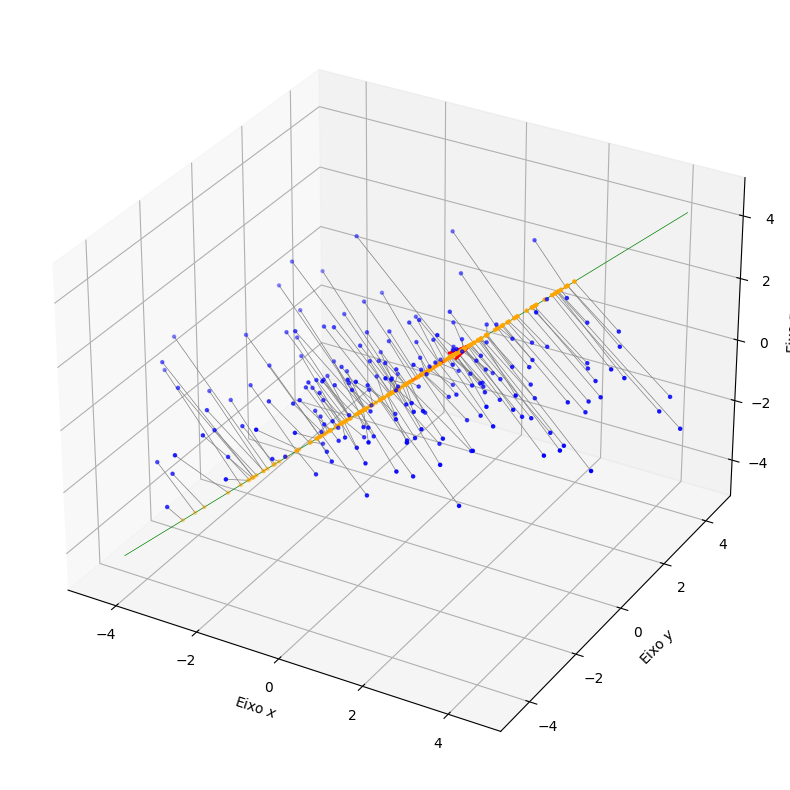

In [ ]:
# creating figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

#1 points
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = 'blue', marker = '.', zorder = -1)

# 2
z = np.array([1, 1, 1])
plotVector3d(z, plt, 'red')

#3
plotLine3d(z, 15, plt)

# matriz de projeção
P = np.array([[1/3,1/3,1/3],[1/3,1/3,1/3],[1/3,1/3,1/3]])

# projetando todos os pontos de X de uma única vez
X_proj = np.matmul(X, P.T)

#4
ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], color = 'orange', marker = '.', zorder = -1)
for original, projected in zip(X, X_proj):
    xx, yy, zz = zip(original, projected)
    ax.plot(xx, yy, zz, color = 'gray', lw = 0.5, zorder = -1)

# plotting figure
ax.set_xlabel(r'Eixo $x$');
ax.set_ylabel(r'Eixo $y$');
ax.set_zlabel(r'Eixo $z$');
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
plt.show()

### Exemplo 3

Considere a transformação linear  $T: \mathbb{R}^3 \rightarrow \mathbb{R}^3$ que mapeia $\mathbf{x}$ em $\mathbf{P}\mathbf{x}$, aonde
$$\mathbf{P} = \begin{bmatrix}
    \frac{1}{2} & 0 & \frac{1}{2} \\
    0 & 1 & 0 \\
    \frac{1}{2} & 0 & \frac{1}{2}
\end{bmatrix}$$

Como nos casos anteriores, a projeção pode ser visualizada com auxílio de uma figura.


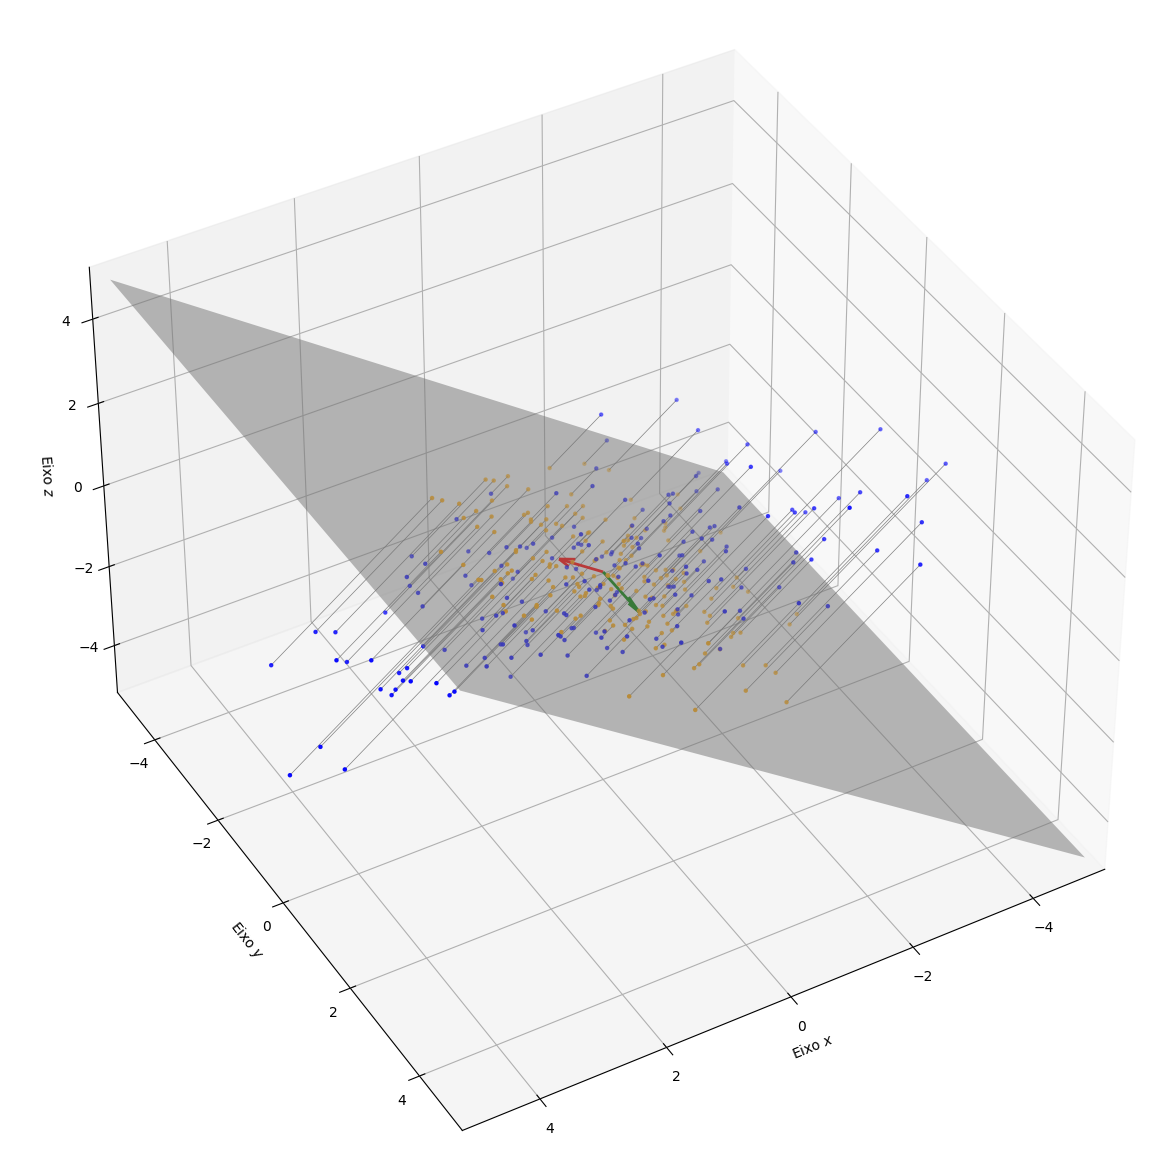

In [ ]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection='3d')

# 1
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = 'blue', marker = '.')

# plot a plane defined by two vectors
# (warning! só funciona para u e v ortogonais!)
u = np.array([1, 0, 1])
v = np.array([0, 1, 0])
u = u / np.linalg.norm(u, ord = 2)
v = v / np.linalg.norm(v, ord = 2)

# 2
plotVector3d(u, plt, 'red')
plotVector3d(v, plt, 'green')

# 3
plotPlane3d(u, v, 10, ax)

# Obtendo matriz de projeção
b = np.c_[u, v]
P = np.matmul(b, b.T)

X_proj = np.matmul(X, P.T)

# 4
ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], color = 'orange', marker = '.', zorder = -1)
for original, projected in zip(X, X_proj):
    xx, yy, zz = zip(original, projected)
    ax.plot(xx, yy, zz, color = 'gray', lw = 0.5, zorder = -1)


# plotting figure
ax.set_xlabel(r'Eixo $x$');
ax.set_ylabel(r'Eixo $y$');
ax.set_zlabel(r'Eixo $z$');
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

# 5
# rotate the axes and update
ax.view_init(40, 60);
#ax.view_init(10, 90);
plt.show()

No entanto, diferentemente dos casos anteriores, a matriz $\mathbf{P}$ vai gerar o subespaço de **duas dimensões** dado por:
$$S = \left\{\mathbf{x} \in \mathbb{R}^3| \mathbf{x} = \left(\alpha, \beta, \alpha\right)^T,\ \alpha, \beta \in \mathbb{R}\right\}.$$


**Why should I care?++**
- Nós sempre conseguimos pegar uma projeção e transformá-la em um subespaço com dimensões menores!

## Direções de variâncias máximas

### Exemplo 1

Considere a figura abaixo. Qual a direção de maior variabilidade dos dados?

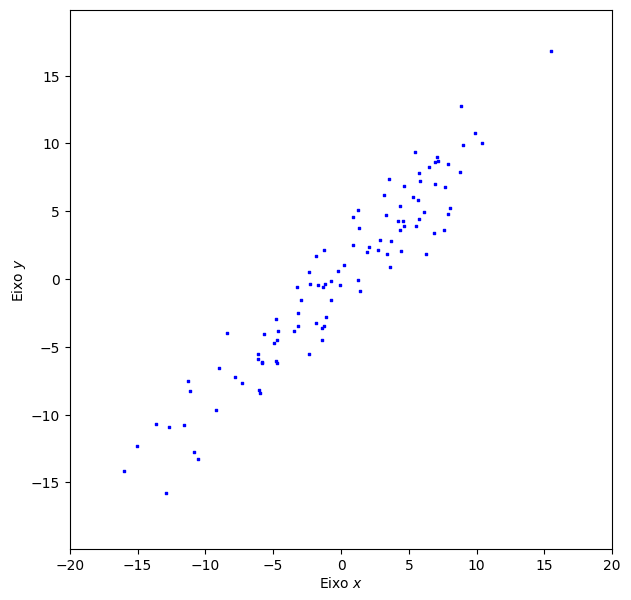

In [ ]:
#@title
def getMaxVarianceDirections(x):
    n, d = x.shape
    sampleSigma = np.matmul(x.T, x) / float(n)
    values, vectors = np.linalg.eigh(sampleSigma)
    return values, vectors

np.random.seed(0)
sigma = np.array([[41, 39], [39, 41]])
X = np.random.multivariate_normal([0, 0], sigma, 100)

fig = plt.figure(figsize = (7,7))
plt.scatter(X[:, 0], X[:, 1], color = 'blue', marker = 's', s = 2)
plt.axis('equal')
plt.xlabel(r'Eixo $x$', labelpad = 2)
_ = plt.ylabel(r'Eixo $y$', labelpad = 2)
plt.xlim((-20, 20))
plt.ylim((-20, 20));

#### Resposta

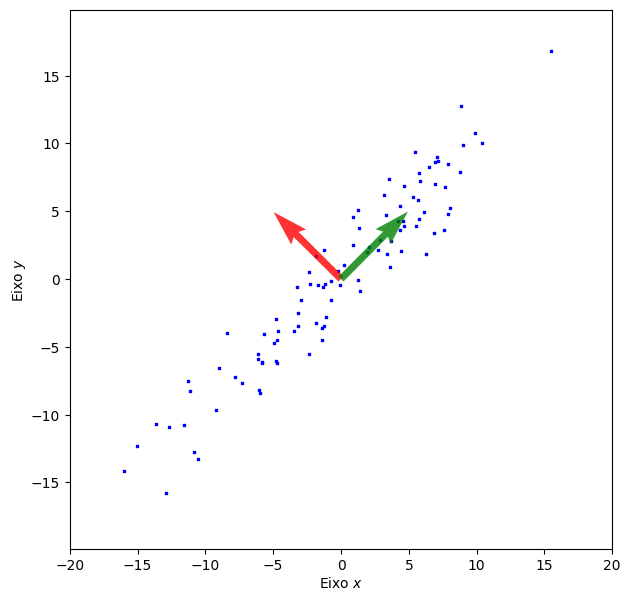

In [ ]:
#@title
fig = plt.figure(figsize = (7,7))

plt.scatter(X[:, 0], X[:, 1], color = 'blue', marker = 's', s = 2)
plt.axis('equal')
plt.xlabel(r'Eixo $x$', labelpad = 2)
_ = plt.ylabel(r'Eixo $y$', labelpad = 2)

# Encontrando as direções ortogonais de variância máxima
values, vectors = getMaxVarianceDirections(X)

# Plotando os vetores das direções de variâncias máximas
plot_vector(7 * vectors[:, 0], color = 'red', zorder = -1)
plot_vector(7 * vectors[:, 1], color = 'green', zorder = -1)

plt.xlim((-20, 20))
plt.ylim((-20, 20));

#### O que podemos fazer com essa direção?

##### 1 - Podemos projetar os pontos no subespaço

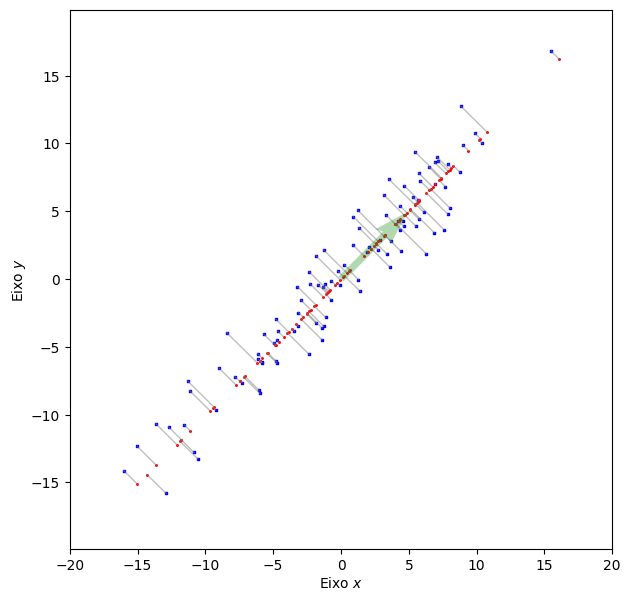

In [ ]:
#@title
fig = plt.figure(figsize = (7,7))

# 1 plot dos dados
plt.scatter(X[:, 0], X[:, 1], color = 'blue', marker = 's', s = 2)
plt.axis('equal')
plt.xlabel(r'Eixo $x$', labelpad = 2)
_ = plt.ylabel(r'Eixo $y$', labelpad = 2)

# Plotando os vetores das direções de variâncias máximas
plot_vector(7 * vectors[:, 1], color = 'green', zorder = -1, alpha = 0.3)

U1 = vectors[:, 1].reshape([2, -1])
P1 = np.matmul(U1, U1.T)
X_proj = np.matmul(P1, X.T).T

# Plotando os pontos no subespaço (em vermelho) e o erro associado às projeções
plt.scatter(X_proj[:, 0], X_proj[:, 1], color = 'red', marker = '.', s = 5)
for original, projected in zip(X, X_proj):
    xx, yy = zip(original, projected)
    _ = plt.plot(xx, yy, color = 'gray', lw = 1, alpha = 0.5)

plt.xlim((-20, 20))
plt.ylim((-20, 20));

Mais que isso, podemos identificar o subespaço!

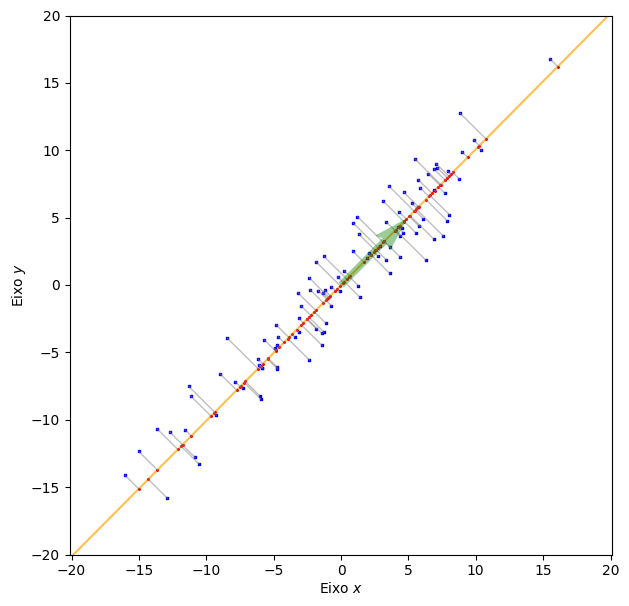

In [ ]:
#@title
fig = plt.figure(figsize = (7,7))

# 1 plot dos dados
plt.scatter(X[:, 0], X[:, 1], color = 'blue', marker = 's', s = 2)
plt.axis('equal')
plt.xlabel(r'Eixo $x$', labelpad = 2)
_ = plt.ylabel(r'Eixo $y$', labelpad = 2)

# Plotando os vetores das direções de variâncias máximas
plot_vector(7 * vectors[:, 1], color = 'green', zorder = -1, alpha = 0.4)

# Plotando os pontos no subespaço (em vermelho) e o erro associado às projeções
plt.scatter(X_proj[:, 0], X_proj[:, 1], color = 'red', marker = '.', s = 5)
for original, projected in zip(X, X_proj):
    xx, yy = zip(original, projected)
    _ = plt.plot(xx, yy, color = 'gray', lw = 1, alpha = 0.5)

# subespaço gerado
max1 = np.dot(P1, [-20, -20])
max2 = np.dot(P1, [20, 20])
plt.plot([max1[0], max2[0]], [max1[1], max2[1]], color = 'orange', alpha = 0.7, zorder = -1)

plt.xlim((-20, 20))
plt.ylim((-20, 20));

##### 2 - Podemos simplificar os dados

Para isso, precisamos identificar as coordenadas nos pontos projetados no subespaço gerado pela direção de maior variância.

O Resultado está na figura abaixo.

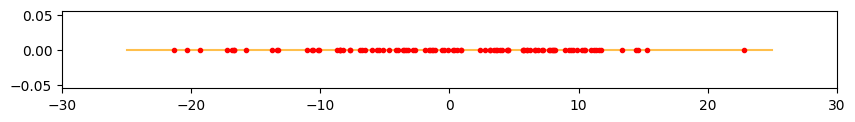

In [ ]:
#@title
fig = plt.figure(figsize = (10,1))
newX = np.matmul(X, U1).ravel()
_ = plt.scatter(newX, [0.0] * len(newX), color = 'red', marker = '.')
plt.plot([-25, 25], [0, 0], color = 'orange', alpha = 0.7, zorder = -1)
plt.xlim((-30, 30));

Ao fazer isso, perderemos informação, mas trabalharemos com menos dados e com dados mais simples.

### Exemplo 2

Vamos fazer os mesmos passos, mas agora do $\mathbb{R}^3$ para o $\mathbb{R}^2$.

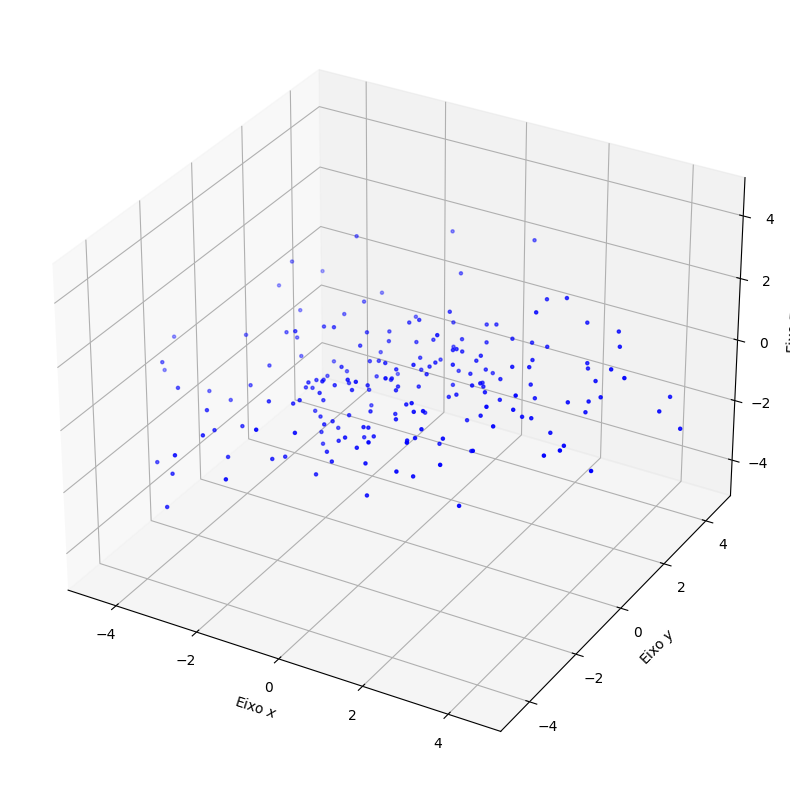

In [ ]:
#@title
np.random.seed(0)
sigma = np.array([[5, 1, 1], [1, 2, 1] ,[1, 1, 1]])
X = np.random.multivariate_normal([0, 0, 0], sigma, 200)
values, vectors = getMaxVarianceDirections(X)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = 'blue', marker = '.', zorder = -1);

ax.set_xlabel(r'Eixo $x$');
ax.set_ylabel(r'Eixo $y$');
ax.set_zlabel(r'Eixo $z$');
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5);

Identificando as direções ortogonais de variâncias máximas

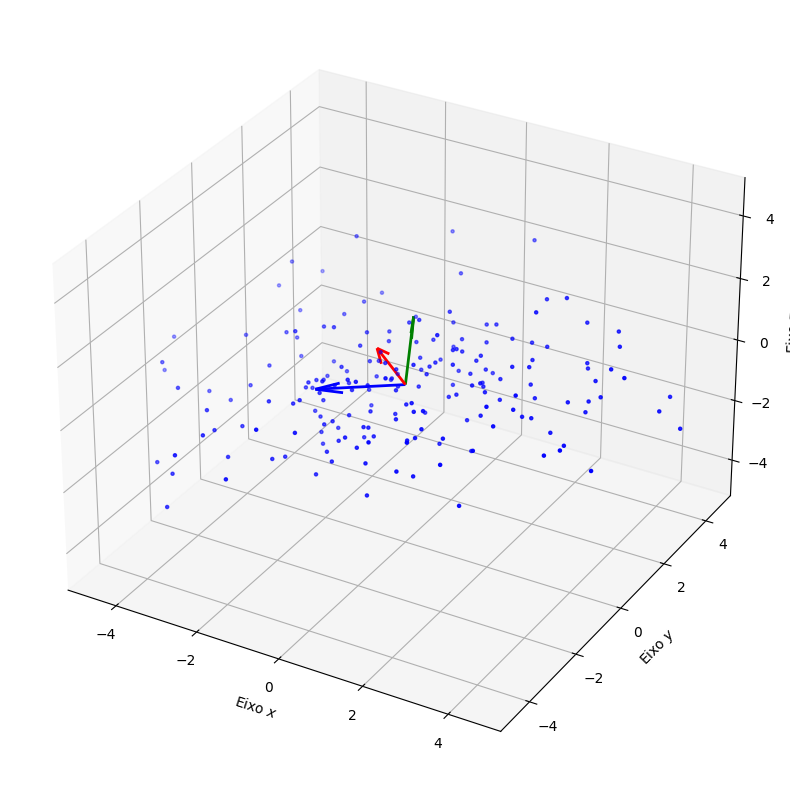

In [ ]:
#@title
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = 'blue', marker = '.', zorder = -1)

plotVector3d(2 * vectors[:, 0], plt, color = 'red')
plotVector3d(2 * vectors[:, 1], plt, color = 'green')
plotVector3d(2 * vectors[:, 2], plt, color = 'blue')

ax.set_xlabel(r'Eixo $x$');
ax.set_ylabel(r'Eixo $y$');
ax.set_zlabel(r'Eixo $z$');
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5);

Projetando os pontos no subespaço de dimensão 2.

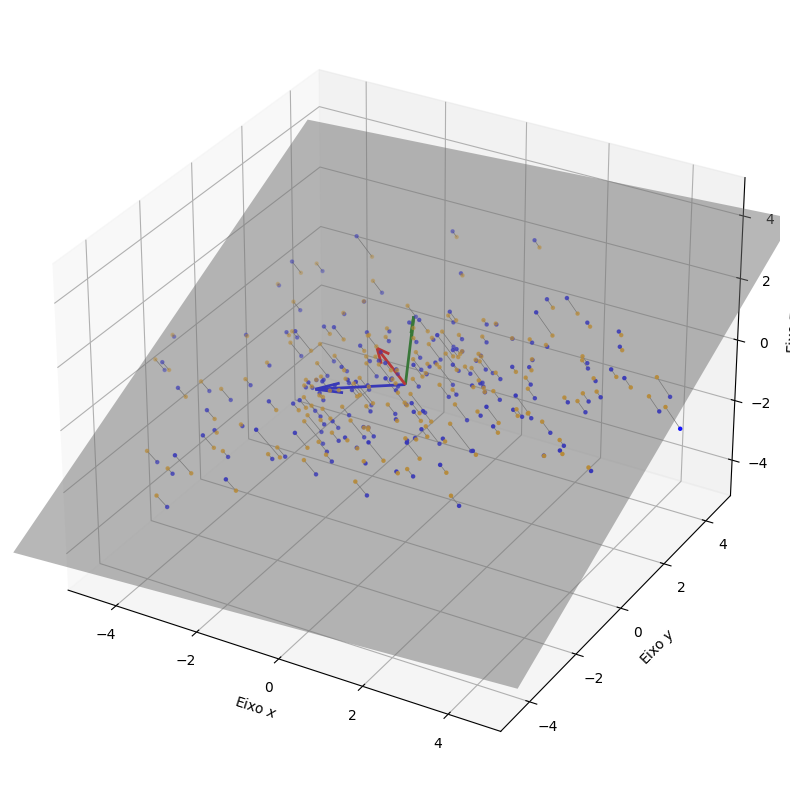

In [ ]:
#@title
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = 'blue', marker = '.', zorder = -1)

plotVector3d(2 * vectors[:, 0], plt, color = 'red')
plotVector3d(2 * vectors[:, 1], plt, color = 'green')
plotVector3d(2 * vectors[:, 2], plt, color = 'blue')

plotPlane3d(vectors[:, 2], vectors[:, 1], 12, ax)

U2 = vectors[:, 2:0:-1]                  # matrix U_2
P2 = np.matmul(U2, U2.T)                 # projection matrix
X_proj = np.matmul(P2, X.T).T            # projecting each point on the 2-dimensional subspace

ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], color = 'orange', marker = '.', zorder = -1)
for original, projected in zip(X, X_proj):
    xx, yy, zz = zip(original, projected)
    ax.plot(xx, yy, zz, color = 'gray', lw = 0.5, zorder = -1)

ax.set_xlabel(r'Eixo $x$');
ax.set_ylabel(r'Eixo $y$');
ax.set_zlabel(r'Eixo $z$');
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5);

#ax.view_init(20, 30);
#ax.view_init(20, 60);
#ax.view_init(20, 120);

Identificando as coordenadas dos pontos projetados no subespaço.

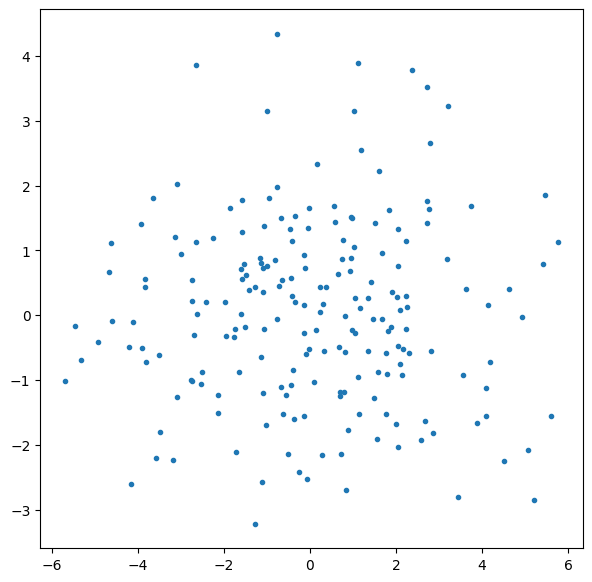

In [ ]:
#@title
fig = plt.figure(figsize = (7,7))

newX = np.matmul(U2.T, X.T).T
plt.scatter(newX[:, 0], newX[:, 1], marker = '.')
plt.show()

#for debug only.. see that we need to multiply second component by -1...
#this is because the directions are multiplied by -1... irrelevant in the end of the day
#import numpy as np
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#pca.fit(X)
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
#XX = pca.transform(X)
#print(XX.shape, newX.shape)
#fig = plt.figure(figsize = (7,7))
#plt.scatter(XX[:, 0], -XX[:, 1], marker = '.')
#print(pca.components_)

### Qual o erro que estamos cometendo?

Quando fazemos a projeção, estamos perdendo informação!

Nas figuras acima, essa perda de informação (para cada ponto) é ilustrada pelas linhas de cor cinza.

Informalmente, **PCA** consiste de projetar os dados em um subespaço de dimensão (consideravelmente) **menor que a original com pouca perda de informação!** - menor perda de informação possível (problema de otimização)

# PCA - Definição

Dados $n$ pontos do $\mathbb{R}^d$ e um inteiro $k < d$, PCA consiste em encontrar um subespaço de dimensão $k$ com a propriedade de que a soma das distâncias ao quadrado dos pontos para suas projeções ortogonais no subespaço é mínima.

Pode-se mostrar que (e não faremos isso nessa disciplina) que este subespaço é formado pelas $k$ direções ortogonais que capturam a maior quantidade de variância dos dados.

# Preliminares (Parte 2)

Voltando a nossa matriz de dados,
$$
\mathbf{X} = \begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1d} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{n1} & x_{n2} & x_{n3} & \dots  & x_{nd}
\end{bmatrix}
$$

Vamos assumir que a **média dos valores de cada coluna da matriz seja zero!**

De fato, essa é uma suposição **muito importante** para o que discutimos até aqui e para o que vamos discutir a seguir.

## Matriz de variâncias e covariâncias

Vamos definir a matriz de variâncias e covariâncias por

$$
\Sigma = \frac{\mathbf{X}^T\mathbf{X}}{n} = \begin{bmatrix}
    \sigma_1^2   & \sigma_{1,2} & \dots  & \sigma_{1,d} \\
    \sigma_{1,2} & \sigma_2^2   & \dots  & \sigma_{2,d} \\
    \vdots & \vdots & \ddots & \vdots \\
    \sigma_{1,d} & \sigma_{2,d} & \dots  & \sigma_d^2
\end{bmatrix},
$$
onde:
- $\sigma_i^2 = \frac{1}{n}\sum_{l=1}^nx_{l,i}^2$ é a variância da $i$-ésima coluna de $\mathbf{X}$
- $\sigma_{i,j} = \frac{1}{n}\sum_{l=1}^nx_{l,i}x_{l,j}$ é a covariância entre as colunas $i$ e $j$ de $\mathbf{X}$.

Observe que $\Sigma$ é uma matriz simétrica.


### Exemplo

In [ ]:
import seaborn as sns

penguins = sns.load_dataset("penguins").dropna()
penguins.drop(columns = ['species', 'island', 'sex'], inplace = True)


penguins

<ipython-input-25-7d2fc450e5b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins.drop(columns = ['species', 'island', 'sex'], inplace = True)


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [ ]:
penguins.cov() # covariância

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,29.906333,-2.462091,50.058195,2595.623304
bill_depth_mm,-2.462091,3.877888,-15.947248,-748.456122
flipper_length_mm,50.058195,-15.947248,196.441677,9852.191649
body_mass_g,2595.623304,-748.456122,9852.191649,648372.487699


In [ ]:
penguins.corr() # correlação

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.228626,0.653096,0.589451
bill_depth_mm,-0.228626,1.000000,-0.577792,-0.472016
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979
body_mass_g,0.589451,-0.472016,0.872979,1.000000


## Autovalores e Autovetores

Seja $T \in \mathbb{R}^{n \times m}$ uma transformação linear e $\mathbf{v} \in \mathbb{R}^m$ um vetor não nulo.

Se
$$T\mathbf{v} = \lambda \mathbf{v},$$
então:
- $\lambda$ é um autovalor de $T$; e
- $\mathbf{v}$ é um autovetor de $T$, associado ao autovalor $\lambda$.

### Exemplo

In [ ]:
x = np.array([[0.5, 0, 0.5],[0, 1, 0],[0.5, 0, 0.5]])
x

array([[0.5, 0. , 0.5],
       [0. , 1. , 0. ],
       [0.5, 0. , 0.5]])

In [ ]:
from numpy import linalg as LA

values, vectors = LA.eig(x)

values

array([1.00000000e+00, 1.11022302e-16, 1.00000000e+00])

In [ ]:
vectors

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.70710678,  0.70710678,  0.        ]])

In [ ]:
np.dot(x, vectors[:, 0])

array([0.70710678, 0.        , 0.70710678])

In [ ]:
np.dot(x, vectors[:, 1])

array([1.11022302e-16, 0.00000000e+00, 1.11022302e-16])

In [ ]:
np.dot(x, vectors[:, 2])

array([0., 1., 0.])

### Lembram como calcula?

Revisão do cálculo de autovalores e autovetores com Trump, Biden e Obama https://www.tiktok.com/@potusmath/video/7232353804031741189

## Teorema Espectral

Seja $T \in \mathbb{R}^{m\times m}$ uma matriz simétrica. Então, é possível decompor $T$ da seguinte forma:
$$
T = \mathbf{U}\mathbf{\Lambda}\mathbf{U}^T =
\begin{bmatrix}
     u_{1,1}  & u_{1,2} & \dots  & u_{1,m} \\
     u_{2,1}  & u_{2,2} & \dots  & u_{2,m} \\
    \vdots    & \vdots & \ddots & \vdots \\
     u_{m,1}  & u_{m,2} & \dots  & u_{m,m}
\end{bmatrix}
\begin{bmatrix}
     \lambda_{1}  & 0 & \dots  & 0 \\
     0  & \lambda_{2} & \dots  & 0 \\
    \vdots    & \vdots & \ddots & \vdots \\
     0  & 0 & \dots  & \lambda_{m}
\end{bmatrix}
\begin{bmatrix}
     u_{1,1}  & u_{1,2} & \dots  & u_{1,m} \\
     u_{2,1}  & u_{2,2} & \dots  & u_{2,m} \\
    \vdots    & \vdots & \ddots & \vdots \\
     u_{m,1}  & u_{m,2} & \dots  & u_{m,m}
\end{bmatrix}^T
$$
Onde:
- $\lambda_1, \dots, \lambda_m$ são os autovalores de $T$ ($\lambda_i \in \mathbb{R})$;
- As colunas de $\mathbf{U}$ são os autovetores de $T$, sendo o autovetor da coluna $i$ associado ao autovalor $\lambda_i$;
- Autovetores associados a autovalores distintos são ortogonais;
- Todas as colunas de $\mathbf{U}$ têm norma 1.

### Exemplo I

In [ ]:
x

array([[0.5, 0. , 0.5],
       [0. , 1. , 0. ],
       [0.5, 0. , 0.5]])

In [ ]:
values, vectors = LA.eigh(x)

In [ ]:
vectors @ np.diag(values) @ vectors.T

array([[0.5, 0. , 0.5],
       [0. , 1. , 0. ],
       [0.5, 0. , 0.5]])

### Exemplo II

In [ ]:
penguins

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [ ]:
cov = penguins.cov()
cov

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,29.906333,-2.462091,50.058195,2595.623304
bill_depth_mm,-2.462091,3.877888,-15.947248,-748.456122
flipper_length_mm,50.058195,-15.947248,196.441677,9852.191649
body_mass_g,2595.623304,-748.456122,9852.191649,648372.487699


In [ ]:
values, vectors = LA.eigh(cov)

In [ ]:
values

array([2.36086761e+00, 1.61549819e+01, 5.07358125e+01, 6.48533462e+05])

In [ ]:
vectors

array([[-1.09847074e-01,  9.41264749e-01, -3.19277728e-01,
         4.00316167e-03],
       [ 9.85686273e-01,  1.44494794e-01,  8.68475312e-02,
        -1.15432728e-03],
       [ 1.27890806e-01, -3.05189864e-01, -9.43542375e-01,
         1.51945474e-02],
       [-3.65748162e-04,  1.03610977e-03,  1.57170210e-02,
         9.99875876e-01]])

In [ ]:
vectors @ np.diag(values) @ vectors.T

array([[ 2.99063334e+01, -2.46209134e+00,  5.00581949e+01,
         2.59562330e+03],
       [-2.46209134e+00,  3.87788831e+00, -1.59472485e+01,
        -7.48456122e+02],
       [ 5.00581949e+01, -1.59472485e+01,  1.96441677e+02,
         9.85219165e+03],
       [ 2.59562330e+03, -7.48456122e+02,  9.85219165e+03,
         6.48372488e+05]])

# PCA - Algoritmo

## Do Teorema Espectral para PCA

Aplique o teorema espectral à matriz de variâncias e covariâncias. Tem-se:
$$
\Sigma = \mathbf{U}\mathbf{\Lambda}\mathbf{U}^T = \begin{bmatrix}
     u_{1,1}  & u_{1,2} & \dots  & u_{1,d} \\
     u_{2,1}  & u_{2,2} & \dots  & u_{2,d} \\
    \vdots    & \vdots & \ddots & \vdots \\
     u_{d,1}  & u_{d,2} & \dots  & u_{d,d}
\end{bmatrix}
\begin{bmatrix}
     \lambda_{1}  & 0 & \dots  & 0 \\
     0  & \lambda_{2} & \dots  & 0 \\
    \vdots    & \vdots & \ddots & \vdots \\
     0  & 0 & \dots  & \lambda_{d}
\end{bmatrix}
\begin{bmatrix}
     u_{1,1}  & u_{1,2} & \dots  & u_{1,d} \\
     u_{2,1}  & u_{2,2} & \dots  & u_{2,d} \\
    \vdots    & \vdots & \ddots & \vdots \\
     u_{d,1}  & u_{d,2} & \dots  & u_{d,d}
\end{bmatrix}^T.
$$
Assuma, sem perda de generalidade, que $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_d$.

Além dos fatos já conhecido do Teorema Espectral, é possível mostrar que:
1. A coluna $i$ de $\mathbf{U}$ representa a $i$-ésima direção de maior variância dos dados;
2. A variância na direção apontada pela coluna $i$ é $\lambda_i$.

As colunas de $\mathbf{U}$ são denominadas **Componentes Principais**.

### Exemplo

In [ ]:
penguins

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [ ]:
cov = penguins.cov()
values, vectors = LA.eigh(cov)

Lambda = np.diag(values[::-1])
U = np.fliplr(vectors)

In [ ]:
Lambda

array([[6.48533462e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.07358125e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.61549819e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.36086761e+00]])

In [ ]:
U

array([[ 4.00316167e-03, -3.19277728e-01,  9.41264749e-01,
        -1.09847074e-01],
       [-1.15432728e-03,  8.68475312e-02,  1.44494794e-01,
         9.85686273e-01],
       [ 1.51945474e-02, -9.43542375e-01, -3.05189864e-01,
         1.27890806e-01],
       [ 9.99875876e-01,  1.57170210e-02,  1.03610977e-03,
        -3.65748162e-04]])

In [ ]:
U @ Lambda @ U.T

array([[ 2.99063334e+01, -2.46209134e+00,  5.00581949e+01,
         2.59562330e+03],
       [-2.46209134e+00,  3.87788831e+00, -1.59472485e+01,
        -7.48456122e+02],
       [ 5.00581949e+01, -1.59472485e+01,  1.96441677e+02,
         9.85219165e+03],
       [ 2.59562330e+03, -7.48456122e+02,  9.85219165e+03,
         6.48372488e+05]])

## Como fazer a projeção?

Seja $k < d$ um inteiro. Defina
$$\mathbf{U}_k = \begin{bmatrix}
     u_{1,1}  & u_{1,2} & \dots  & u_{1,k} \\
     u_{2,1}  & u_{2,2} & \dots  & u_{2,k} \\
    \vdots    & \vdots & \ddots & \vdots \\
     u_{d,1}  & u_{d,2} & \dots  & u_{d,k}
\end{bmatrix}$$
como sendo a matriz $\mathbf{U}$ truncada ($k$ primeiras colunas).

Para fazer a projeção, i.e., para reduzir a dimencionalidade da matriz $\mathbf{X}$, precisamos computar
$$\mathbf{X}_k = \mathbf{X}\mathbf{U}_k.$$

A questão que sobra é: **qual o $k$ adequado?**

### Exemplo I

Voltando no exemplo do conjunto de dados ``penguins``.

As variâncias ao longo de cada direção (Componente Principal) são dadas pelos elementos da diagonal da matriz $\Lambda$.

In [ ]:
Lambda

array([[6.48533462e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.07358125e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.61549819e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.36086761e+00]])

Veja que do total da variância, a maior parte é concentrada ao longo da primeira componente. Isso indica que $k = 1$ é uma boa escolha.

**Warning:** vamos revisitar esse procedimento depois.

## Pseudocódigo

**Entrada:**
1. Matriz de dados $\mathbf{X} \in \mathbb{R}^{n \times d}$
2. $0 \le \alpha \le 1$, fração da variância total a ser considerada

**Passos:**
1. $\mathbf{Z} \leftarrow$ matriz $\mathbf{X}$ após centralização/pré-processamento
2. $\Sigma \leftarrow \frac{\mathbf{Z}^T\mathbf{Z}}{n}$
3. $\lambda_1, \dots, \lambda_d \leftarrow$ autovalores de $\Sigma$ ordenados decrescentemente
4. $\mathbf{u}_1, \dots, \mathbf{u}_d \leftarrow$ autovetores de $\Sigma$ ($\mathbf{u_i}$ está associado a $\lambda_i$)
5. $f(k) \leftarrow \frac{\sum_{i=1}^k\lambda_i}{\sum_{i=1}^d\lambda_i}$, para $k = 1, \dots, d$
6. Escolha o menor $k$ tal que $f(k) \ge \alpha$
7. $\mathbf{U}_k \leftarrow$ matriz cujas colunas são $\mathbf{u}_1, \dots, \mathbf{u}_k$

**Saída:**
1. Retorne $\mathbf{Z}\mathbf{U}_k$



# PCA - Scikit-Learn

A biblioteca ``scikit-learn`` possui a classe ``PCA`` que encapsula tudo o que foi discutido até agora (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

## Exemplo 1

Exemplo baseado em https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
import pandas as pd

X, y = load_wine(return_X_y=True, as_frame = True);
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [ ]:
pca = PCA(n_components = 13)
pca.fit(X);

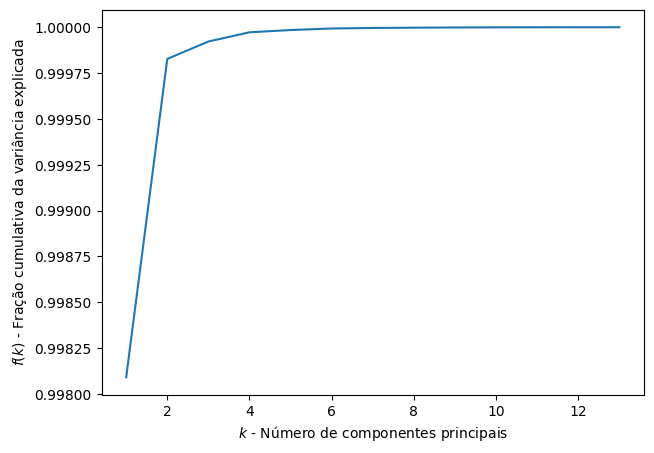

In [ ]:
#@title
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

In [ ]:
pca = PCA(n_components = 2)
X2 = pca.fit_transform(X)

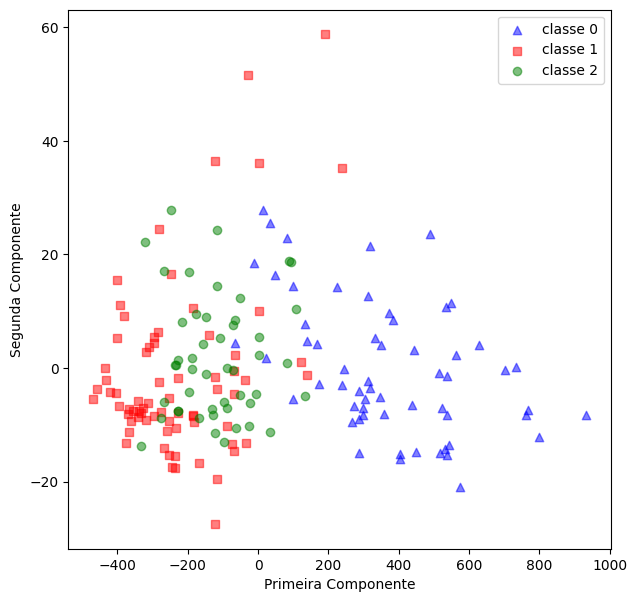

In [ ]:
#@title
plt.figure(figsize=(7, 7))
for l, c, m in zip(range(0, 3), ("blue", "red", "green"), ("^", "s", "o")):
  plt.scatter(X2[y == l, 0], X2[y == l, 1], color=c, label="classe %s" % l, alpha=0.5, marker=m)
plt.xlabel('Primeira Componente');
plt.ylabel('Segunda Componente');
plt.legend(loc = 'best');

## Exemplo 2

O que fizemos no Exemplo 1 está correto, no entanto, repare que as colunas de $\mathbf{X}$ têm unidades de medidas diferentes. Por isso, os valores de colunas estão em ordens de grandezas diferentes.

Neste tipo de situação, pode também ser interessante transformar os valores das colunas para que todas tenham a "mesma ordem de grandeza".

In [ ]:
Z = X.copy()
scaler = StandardScaler(with_mean=True, with_std=True)

# Colunas de Z terão média 0 e desvio padrão 1
Z[Z.columns] = scaler.fit_transform(Z)
Z.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.382808e-16,-1.197544e-16,-8.370333e-16,-3.991813e-17,-3.991813e-17,0.000000,-3.991813e-16,3.592632e-16,-1.197544e-16,2.494883e-17,1.995907e-16,3.193450e-16,-1.596725e-16
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-0.885468,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,0.095960,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,0.808997,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [ ]:
pca = PCA(n_components = 13)
pca.fit(Z.values);

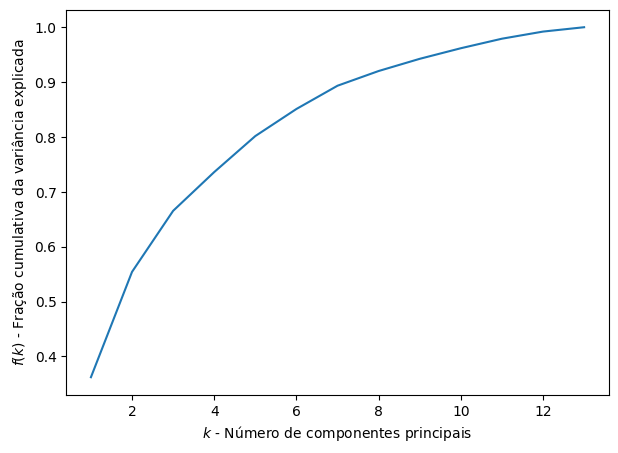

In [ ]:
#@title
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

In [ ]:
pca = PCA(n_components = 2)
X2 = pca.fit_transform(Z)

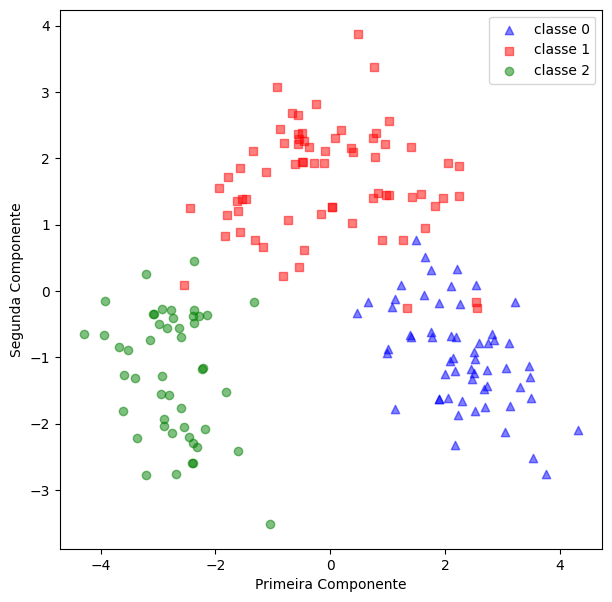

In [ ]:
#@title
plt.figure(figsize=(7, 7))

for l, c, m in zip(range(0, 3), ("blue", "red", "green"), ("^", "s", "o")):
  plt.scatter(X2[y == l, 0], X2[y == l, 1], color=c, label="classe %s" % l, alpha=0.5, marker=m)

plt.xlabel('Primeira Componente');
plt.ylabel('Segunda Componente');
plt.legend(loc = 'best');

# What is next?

Há várias extensões, na própria ``scikit-learn``, especialmente para trabalhar com matrizes esparsas e muito grandes...
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html